In [1]:
import os as os

#Data Cleaning & Visualization
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
#ML Regression, Decision Trees
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

#ML PCA & Clustering
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn import decomposition, preprocessing, cluster, tree
import pydotplus
from yellowbrick.cluster.silhouette import SilhouetteVisualizer


#ML Recommendation Algorithm 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# TED Talks

TED Talks is a facinating source of content. As a TED Talk fan, I wanted to understand better the content available. 

As a user of the TED Talks podcast, I had some general questions: 

- Which are the most viewed videos? (To add to my  list!)
- Is there a sustancial difference between liked and viewed?. If so, which are the top videos on each?
- Are there any authors that have presented more than once?
- Which content categories are most viewed?
- Which content categories are made available the most?
- Could the duration of the video affect the likebility of the videos? (My hunch is yes!)
- When was the video published? (Assuming that older videos can have more likes than newer)
- What type of event was this part of? Was it a Women, or a specific location?

The dataset used to answer some of these questions is a combination of the dataset Kaggle offers of [TED Talks](https://www.kaggle.com/datasets/ashishjangra27/ted-talks) and other information I scrapped directly from the TED Talk website. To review the overall project that includes the scrapping code, you can read [my post that is in the works.](https://github.com/aaas24/code_library/blob/main/ted_talks/2022-03-21-Scraping-%26-Analyzing-TED-Talks.md) 


I have divided th content into several steps: 

**STEP 1** - PREPROCESSING THE DATA</br>
\--------------------------------------------

* Transformed the dataset obtained into organized panda Dataframes using pandas library</br>

**STEP 2** - DATA EXPLORATION</br>
\--------------------------------------------

* Applied Principal Component Analysis (PCA) to understand key columns of main dataset</br>
* Applied Clustering based on identified most important PCA's</br>

**STEP 3** - ANALYSYS</br>
\--------------------------------------------
* Answered main posed questions</br>

**STEP 4** - ML LEARNING</br>
\--------------------------------------------

* Applied Regression Model to predict video with good performance and identified key features</br>
</br>

#  Step 1: Preprocessing Data

We will proceed to clean and generate two base DataFrame to be used in the following steps.

In [2]:
def preprocessing(df):  
    '''
    This function does the main cleaning to create a base dataFrame called 'df`
    '''
    #drop duplicated columns
    drop_column=['description2', 'Unnamed: 0', 'link', 'author_y', 'title','url', 'title_1']
    df=df.drop(drop_column,axis=1)
    
    #renaming
    column_names=['author', 'title', 'description_1', 'duration_seg',
       'date_released', 'keywords', 'description_2', 'date_recorded', 'views',
       'likes']

    df.columns=column_names

    #
    #MODIFYING COLUMN: date_recorded
    #
    df['date_recorded']= pd.to_datetime(df['date_recorded'], format='%B %Y')
  
    ##separate data into new Column
    list_months=[]
    list_years=[]
    for i in range(df.shape[0]):
        list_months.append(df['date_recorded'][i].month)
        list_years.append(df['date_recorded'][i].year)
    df['date_recorded_year']=list_years
    df['date_recorded_month']=list_months

    #
    #MODIFYING COLUMN: date_released
    #
    column='date_released'
    df[column]= pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S')

    ##separate data into new Column
    list_months=[]
    list_years=[]
    list_hours=[]
    list_minutes=[]
    for i in range(df.shape[0]):
        list_months.append(df[column][i].month)
        list_years.append(df[column][i].year)
        list_hours.append(df[column][i].hour)
        list_minutes.append(df[column][i].minute)
    df[column+'_year']=list_years
    df[column+'_month']=list_months
    df[column+'_hour']=list_hours
    df[column+'_minute']=list_minutes

    #
    #MODIFYING COLUMN: 'keywords'
    #
    df_key=df.keywords
    i=0
    df_result=pd.DataFrame()
    ##transforming line into string
    for line in df_key:
        line=(str(line).replace("[","").replace("]","").split(','))
        new_line=[]
        ##removing additional spaces in words and converting the into lower case
        for word in line:
            word=word.lower().replace(' ', '')[1:-1]
            new_line.append(word)
        ##transforming line into string
        new_line=str(new_line).replace("[","").replace("]","")
        ##writting line into dataframe
        df_result.at[i,'keywords2']=new_line
        i=i+1
  
    df=pd.concat([df,df_result], axis=1)

    #drop initial columns
    drop_columns=['date_recorded','date_released', 'keywords']
    df=df.drop(drop_columns, axis=1)
    
    return(df)

In [3]:
def create_dummies_file(df):
    '''
    This function does: 
    1) convert df.keywords into dummy columns
    2) Adds dummy columns to 'df'
    3) creates a file called 'keywords.csv' in order to manually map new categories from keywords
    '''
    #converting keywords into dummy columns
    df2=df.keywords2.str.get_dummies(',')

    #joining with df
    df=pd.concat([df,df2], axis=1)
    
    #removing 'ted' column
    column_to_drop=df.columns[362]
    df2=df.drop(column_to_drop, axis=1)

    #counting dummies and creating file to rename categories
    dummy_columns=pd.Series(np.arange(15,349,1))[1:]
    df_dummies=df.iloc[:,dummy_columns].sum().reset_index()
    df_dummies.columns=['keyword', 'sum']
    df2=df_dummies.copy()
    (df2
     .groupby(['keyword'])
     .agg({'sum':'sum'})
    )
    df2=df2.sort_values(by='sum', ascending=False)
    cwd=os.getcwd()
    df2.to_csv(cwd+'/keywords.csv')
    return df

In [4]:
def dummy_data(df):
    '''
    This function takes the keyword_categories.csv file and creates a new dataframe 'df_dummies' to analyze the keywords
    '''
    # cwd=os.getcwd()
    # categories=pd.read_csv(cwd+'/keywords_categories.csv')
    #for github
    categories=pd.read_csv('https://github.com/aaas24/code_library/raw/main/ted_talks/2_preprocessing/keywords_categories.csv')

    #transforming categories
    new_cat=(categories.columns.values.tolist())
    dic={key: None for key in new_cat}

    ##creating dictionary with categories file
    for column in range (0,categories.shape[1]):
        dic_values=[]
        key=new_cat[column]
        for row in range (0,categories.shape[0]):
            value=categories.iloc[row,column]
            if value is np.nan:
                pass
            else:
                value=value.replace(' ', '')[1:-1]
                dic_values.append(value)
        dic.update({key:dic_values})

    ##adding column to df with 
    dummy_columns=pd.concat([df.iloc[:,16:349], df[['likes', 'views']]], axis=1)
    df_dummies=dummy_columns.iloc[:,:-2].sum().reset_index()
    df_dummies.columns=['sub_category', 'num_talks']
    
    #adding categories to subcategories
    list_categories=[]
    for i in range (0, len(set(df_dummies['sub_category']))):
        keyword=df_dummies['sub_category'][i][2:-1]
        ###find category of keyword in dictionary
        for key, value_list in dic.items():
            for x in value_list:
                if keyword==x:
                    category=key
        ###add category to list
        list_categories.append(category)
    
    ##add list_categories to df
    df_dummies['category']=list_categories

    #add num likes and views
    list_likes=[]
    list_views=[]
    for row in range (0,df_dummies.shape[0]):
        subcategory=df_dummies.iloc[row,0]
        df2=dummy_columns[[subcategory,'likes','views']]
        df2.columns=['A', 'likes','views']
        df3=(df2
             .query('A>0')
             .groupby('A')
             .agg({'likes': ['sum'], 'views':['sum']})
            )
        
        list_likes.append(df3.iloc[0,0])
        list_views.append(df3.iloc[0,1])
    #add lists to df_dummies
    df_dummies['likes']=list_likes
    df_dummies['views']=list_views
    return df_dummies

In [5]:
def main():
    #load data
    raw_data=pd.read_csv('https://github.com/aaas24/code_library/raw/main/ted_talks/1_raw_data/final_raw_data.csv')
    df=raw_data.copy()

    df=preprocessing(df)
    df=create_dummies_file(df)
    df_dummies=dummy_data(df)
    return(df, df_dummies)


In [6]:
df=main()[0]
df.head(5)

,author,title,description_1,duration_seg,description_2,views,likes,date_recorded_year,date_recorded_month,date_released_year,...,'water','weather','windenergy','women','womeninbusiness','work','work-lifebalance','writing','youth','ted'
0,Ozawa Bineshi Albert,Climate action needs new frontline leadership,"""We can't rely on those who created climate ch...",834,"""We can't rely on those who created climate ch...",404000,12000,2021,12,2022,...,0,0,0,0,0,0,0,0,0,1
1,Sydney Iaukea,The dark history of the overthrow of Hawaii,"""On January 16th, 1895, two men arrived at Lil...",0,"""On January 16th, 1895, two men arrived at Lil...",214000,6400,2022,2,2022,...,0,0,0,1,0,0,0,0,0,1
2,Martin Reeves,Why play is essential for business,"""To thrive in today's competitive economy, you...",665,"""To thrive in today's competitive economy, you...",412000,12000,2021,9,2022,...,0,0,0,0,0,1,0,0,0,1
3,James K. Thornton,Why is China appointing judges to combat clima...,"""Why is China appointing thousands of judges t...",695,"""Why is China appointing thousands of judges t...",427000,12000,2021,10,2022,...,0,0,0,0,0,0,0,0,0,1
4,Mahendra Singhi,Cement's carbon problem -- and 2 ways to fix it,"""Cement is vital to modernizing all kinds of i...",671,"""Cement is vital to modernizing all kinds of i...",2400,72,2021,10,2022,...,0,0,0,0,0,0,0,0,0,1


In [7]:
df_dummies=main()[1]
df_dummies.head(5)

,sub_category,num_talks,category,likes,views
0,'3dprinting',9,technology,201574,6655100
1,'activism',352,values & emotions,21752759,714057797
2,'addiction',20,health,1870500,60982000
3,'africa',197,global,9097799,299541000
4,'aging',93,society,8152092,269034199


# Step 2: Data Exploration

With the two dataframes created on previous step, we proceed to apply data science techniques to undertand the dataset and explore key variables.

## Principal Component Analysis (PCA)

Even through the dataset is intuitively simple to understand, I wanted to practice doing a PCA analysis, which is normaly reserved for models with many variables. To do this I followed these steps: 

- Prepared the dataFrame to use by dropping all categorical columns & dummy columns from `df` and standarized the data using the sklearn.preprocessing library called 'StandardScaler'
- Used the decomposition.PA from the Sklearn library to create dataframe with components columns: 
* Applied Principal Component Analysis (PCA) to understand key columns of main dataset</br>
* Applied Clustering based on identified most important PCA's</br>
* Explored key variables: dates, duration, keywords</br>

In [8]:
df.head(3)

,author,title,description_1,duration_seg,description_2,views,likes,date_recorded_year,date_recorded_month,date_released_year,...,'water','weather','windenergy','women','womeninbusiness','work','work-lifebalance','writing','youth','ted'
0,Ozawa Bineshi Albert,Climate action needs new frontline leadership,"""We can't rely on those who created climate ch...",834,"""We can't rely on those who created climate ch...",404000,12000,2021,12,2022,...,0,0,0,0,0,0,0,0,0,1
1,Sydney Iaukea,The dark history of the overthrow of Hawaii,"""On January 16th, 1895, two men arrived at Lil...",0,"""On January 16th, 1895, two men arrived at Lil...",214000,6400,2022,2,2022,...,0,0,0,1,0,0,0,0,0,1
2,Martin Reeves,Why play is essential for business,"""To thrive in today's competitive economy, you...",665,"""To thrive in today's competitive economy, you...",412000,12000,2021,9,2022,...,0,0,0,0,0,1,0,0,0,1


In [9]:
#dropping categorical columns
df_model=df.drop(['author','title','description_1', 'description_2', 'keywords2'], axis=1).iloc[:,:9]
df_model.head(3)

,duration_seg,views,likes,date_recorded_year,date_recorded_month,date_released_year,date_released_month,date_released_hour,date_released_minute
0,834,404000,12000,2021,12,2022,2,9,41
1,0,214000,6400,2022,2,2022,2,10,13
2,665,412000,12000,2021,9,2022,2,9,51


In [10]:

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os as os

#ML Regression, Decision Trees
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

#ML PCA
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn import decomposition, preprocessing, cluster, tree
import pydotplus
from yellowbrick.cluster.silhouette import SilhouetteVisualizer


X = df_model
std = preprocessing.StandardScaler()
X_std = pd.DataFrame(std.fit_transform(X), columns=X.columns)
X_std

,duration_seg,views,likes,date_recorded_year,date_recorded_month,date_released_year,date_released_month,date_released_hour,date_released_minute
0,0.264675,-0.464984,-0.470418,1.309927,1.591529,1.446482,-1.209561,-0.513606,0.637580
1,-1.536697,-0.518216,-0.522405,1.528134,-1.311085,1.446482,-1.209561,-0.256235,-0.721544
2,-0.100352,-0.462743,-0.470418,1.309927,0.720745,1.446482,-1.209561,-0.513606,1.122981
3,-0.035554,-0.458540,-0.470418,1.309927,1.011006,1.446482,-1.209561,-0.513606,0.831740
4,-0.087392,-0.577500,-0.581151,1.309927,1.011006,1.446482,-1.209561,-0.513606,0.491959
...,...,...,...,...,...,...,...,...,...
5435,0.605942,3.624367,3.670033,-1.963185,-1.311085,-2.359267,0.221125,2.060102,-0.818624
5436,0.977448,19.594017,18.913574,-1.963185,-1.311085,-2.359267,-0.065012,2.060102,-0.818624
5437,0.873772,0.234319,0.235130,-1.963185,-1.311085,-2.359267,-0.065012,2.060102,-0.818624
5438,0.873772,-0.017834,-0.024809,-1.963185,-1.311085,-2.359267,-0.065012,2.060102,-0.818624


In [11]:
pca = decomposition.PCA()
pca_X = pd.DataFrame(pca.fit_transform(X_std), columns=[f'PC{i+1}' for i in range(len(X.columns))])
pca_X

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,-2.353050,0.640153,0.284316,-0.603109,0.929410,-1.291875,0.239075,-0.030687,0.003502
1,-1.731059,0.280292,-1.858844,-1.413271,-1.016366,0.526591,1.118925,-0.092696,0.003599
2,-2.317451,0.717196,0.179404,-1.127605,0.461949,-0.588923,-0.108814,-0.019253,0.005456
3,-2.306187,0.672507,0.132764,-0.911835,0.568249,-0.854332,0.092875,-0.021647,0.008290
4,-2.314708,0.465819,-0.036364,-0.827110,0.516955,-0.914731,0.337036,-0.014700,0.002438
...,...,...,...,...,...,...,...,...,...
5435,5.811723,2.436950,-1.161030,0.723981,0.493394,0.399537,-0.999472,-0.290728,-0.032605
5436,17.210024,21.196511,-2.006792,2.509708,1.380970,-0.442098,-0.713892,-0.125093,0.480695
5437,3.392499,-1.689732,-0.931235,0.032325,0.647645,0.457366,-0.976476,-0.341491,-0.000921
5438,3.206750,-1.997994,-0.916213,-0.001125,0.638960,0.469690,-0.979716,-0.344335,0.004586


In [12]:
#variance or relevance of PCAs. In this case the first 3 hold ~50% of representation of the data
pca.explained_variance_ratio_


array([2.61155893e-01, 2.09808747e-01, 1.27262369e-01, 1.19521228e-01,
       1.01198399e-01, 9.06161518e-02, 8.05875806e-02, 9.81195975e-03,
       3.76713129e-05])

In [13]:
# Components
# First component is .36 * Views + .36 * likes + 0.19 * Dur ... etc
pca.components_[0]

array([ 0.19279606,  0.36279544,  0.36266011, -0.52126245, -0.25986923,
       -0.53505052, -0.01655183,  0.10777476, -0.2495432 ])

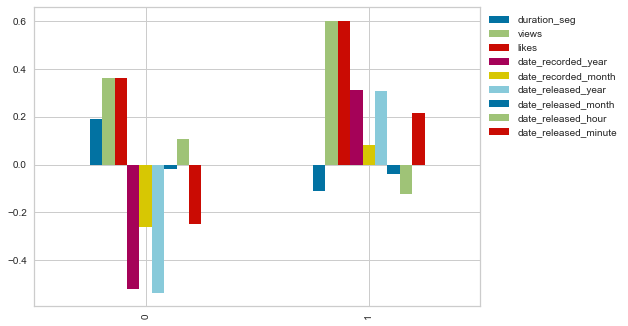

In [14]:
# What columns make up the components 1 & 2?
# 1 - Views & Likes
# 2 - Recorded & Released Year
(pd.DataFrame(pca.components_, columns=X.columns)
 .iloc[:2]
 .plot.bar()
 .legend(bbox_to_anchor=(1,1)))

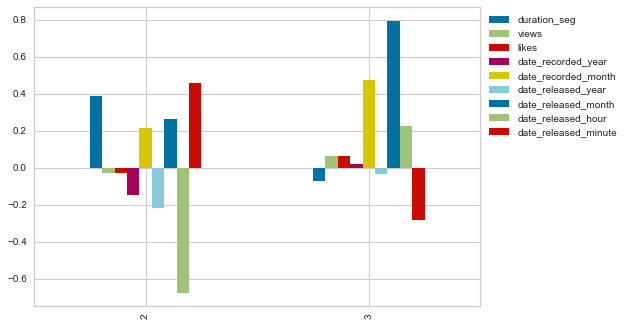

In [15]:
# What columns make up the components 3 & 4?
(pd.DataFrame(pca.components_, columns=X.columns)
 .iloc[2:4]
 .plot.bar()
 .legend(bbox_to_anchor=(1,1)))

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

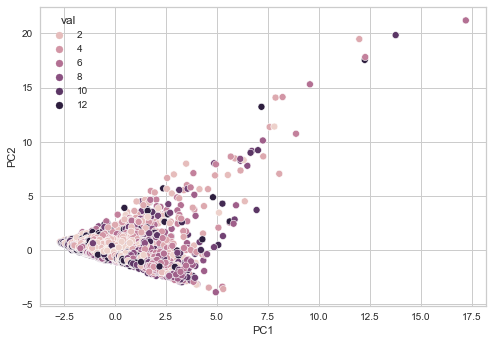

In [16]:
# Plot with Seaborn
x='PC1'
y='PC2'
val='date_released_month'
sns.scatterplot(x=x, y=y, 
                data=pca_X.assign(val=X[val]), 
                hue='val')

## Clustering

We selected 4 clusters. We can describe the clusters as: 

* 0 - Newer videos released in fall
* 1 - Newer videos released in earlier in the year
* 2 - Older videos, longer duration in seg
* 3 - Highest views & likes

<AxesSubplot:>

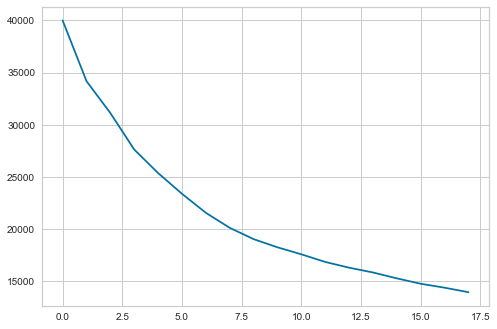

In [17]:
inerts = []
for i in range(2, 20):
    k = cluster.KMeans(n_clusters=i, random_state=42)
    k.fit(X_std)
    inerts.append(k.inertia_)
    
pd.Series(inerts).plot()

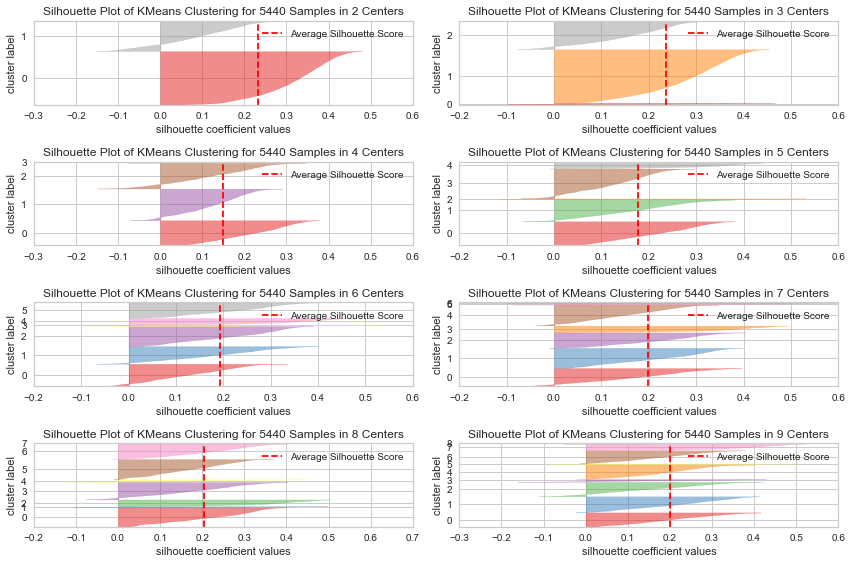

In [18]:
start, end = 2, 10
cols = 2
rows = ((end - start) // cols)
fix, axes = plt.subplots(rows, cols, figsize=(12,8))
axes = axes.reshape(cols * rows)
for i, k in enumerate(range(start, end), 0):
    ax = axes[i]
    sil = SilhouetteVisualizer(cluster.KMeans(n_clusters=k, random_state=42), ax=ax)
    sil.fit(X_std)
    sil.finalize()
plt.tight_layout()

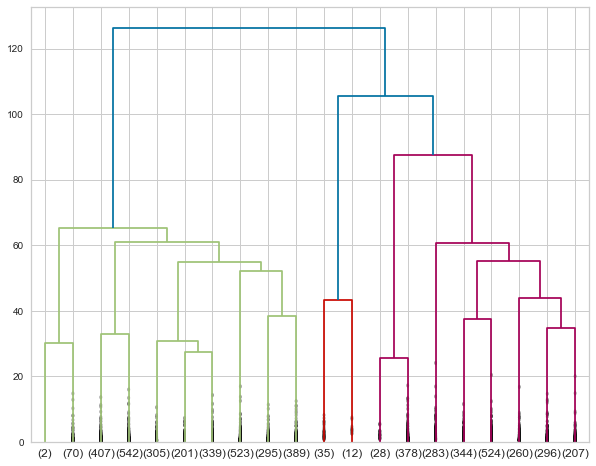

In [19]:
# Try another mechanism
fig, ax = plt.subplots(figsize=(10,8))
hierarchy.dendrogram(hierarchy.linkage(X_std, method='ward'),
                    truncate_mode='lastp', p=20, show_contracted=True)
pass  # here to hide return value of above

In [20]:
# going to choose 4 clusters
k9 = cluster.KMeans(n_clusters=4, random_state=42)
k9.fit(X_std)
labels = k9.predict(X_std)

In [21]:
labels

array([1, 1, 1, ..., 2, 2, 2], dtype=int32)

In [22]:
X.assign(label=labels)

,duration_seg,views,likes,date_recorded_year,date_recorded_month,date_released_year,date_released_month,date_released_hour,date_released_minute,label
0,834,404000,12000,2021,12,2022,2,9,41,1
1,0,214000,6400,2022,2,2022,2,10,13,1
2,665,412000,12000,2021,9,2022,2,9,51,1
3,695,427000,12000,2021,10,2022,2,9,45,1
4,671,2400,72,2021,10,2022,2,9,38,1
...,...,...,...,...,...,...,...,...,...,...
5435,992,15000000,458000,2006,2,2006,7,19,11,3
5436,1164,72000000,2100000,2006,2,2006,6,19,11,3
5437,1116,2900000,88000,2006,2,2006,6,19,11,2
5438,1116,2000000,60000,2006,2,2006,6,19,11,2


In [23]:
(X.assign(label=labels)
  .groupby('label')
  .agg(['mean', 'var'])
  .T
)

label                                 0             1             2  \
duration_seg         mean  6.350369e+02  6.455351e+02  8.631271e+02   
                     var   1.554876e+05  2.034898e+05  2.523900e+05   
views                mean  1.579249e+06  1.829965e+06  1.887791e+06   
                     var   2.991364e+12  4.134593e+12  3.745353e+12   
likes                mean  4.808912e+04  5.563381e+04  5.721366e+04   
                     var   2.814619e+09  3.858025e+09  3.489601e+09   
date_recorded_year   mean  2.017660e+03  2.017270e+03  2.009742e+03   
                     var   5.702002e+00  6.409831e+00  1.294749e+01   
date_recorded_month  mean  8.097666e+00  6.384876e+00  5.200713e+00   
                     var   7.532558e+00  1.283434e+01  1.070241e+01   
date_released_year   mean  2.018230e+03  2.018567e+03  2.010543e+03   
                     var   4.012342e+00  3.833456e+00  5.029017e+00   
date_released_month  mean  9.693489e+00  3.415414e+00  6.343824e+00   
                     var   2.869116e+00  3.324437e+00  1.088053e+01   
date_released_hour   mean  1.113759e+01  1.091032e+01  1.094240e+01   
                     var   6.582163e+00  7.480315e+00  3.244410e+01   
date_released_minute mean  3.214742e+01  3.283713e+01  1.764311e+01   
                     var   3.840004e+02  3.897591e+02  3.564008e+02   

label                                 3  
duration_seg         mean  7.886462e+02  
                     var   1.738138e+05  
views                mean  2.616923e+07  
                     var   1.764240e+14  
likes                mean  7.927385e+05  
                     var   1.495301e+11  
date_recorded_year   mean  2.012277e+03  
                     var   1.195337e+01  
date_recorded_month  mean  5.215385e+00  
                     var   1.101538e+01  
date_released_year   mean  2.013262e+03  
                     var   1.528990e+01  
date_released_month  mean  5.630769e+00  
                     var   1.079904e+01  
date_released_hour   mean  1.152308e+01  
                     var   2.059712e+01  
date_released_minute mean  2.761538e+01  
                     var   3.713341e+02

In [24]:
# how many in each cluster?
pd.Series(labels).value_counts().sort_index()

0    1628
1    2063
2    1684
3      65
dtype: int64

In [25]:
# Add coloring to aid impact to clusters
(X.assign(label=labels)
  .groupby('label')
  .mean()
  .T
 .style.background_gradient(cmap='RdBu', axis=1)
)

label,0,1,2,3
duration_seg,635.036855,645.535143,863.127078,788.646154
views,1579248.831081,1829964.674746,1887790.967933,26169230.769231
likes,48089.123464,55633.806108,57213.657957,792738.461538
date_recorded_year,2017.660319,2017.270480,2009.741686,2012.276923
date_recorded_month,8.097666,6.384876,5.200713,5.215385
date_released_year,2018.229730,2018.566651,2010.543349,2013.261538
date_released_month,9.693489,3.415414,6.343824,5.630769
date_released_hour,11.137592,10.910325,10.942399,11.523077
date_released_minute,32.147420,32.837130,17.643112,27.615385


### Clusters
* 0 - Newer videos released in fall
* 1 - Newer videos released in earlier in the year
* 2 - Older videos, longer duration in seg
* 3 - Highest views & likes

In [26]:
# describe a column for each label
(X.assign(label=labels)
  .groupby('label')
  .date_recorded_year
  .describe()
)

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,1628.0,2017.660319,2.387886,2009.0,2016.0,2018.0,2020.0,2021.0
1,2063.0,2017.270480,2.531764,2009.0,2015.0,2017.0,2019.0,2022.0
2,1684.0,2009.741686,3.598263,1970.0,2009.0,2010.0,2012.0,2021.0
3,65.0,2012.276923,3.457364,2004.0,2010.0,2013.0,2015.0,2019.0


In [27]:
# describe a label in a cluster
(X.assign(label=labels)
 .query('label == 0')
 .describe()
)

,duration_seg,views,likes,date_recorded_year,date_recorded_month,date_released_year,date_released_month,date_released_hour,date_released_minute,label
count,1628.000000,1.628000e+03,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.0
mean,635.036855,1.579249e+06,48089.123464,2017.660319,8.097666,2018.229730,9.693489,11.137592,32.147420,0.0
std,394.319134,1.729556e+06,53052.986698,2.387886,2.744551,2.003083,1.693846,2.565573,19.595928,0.0
min,0.000000,1.200000e+03,37.000000,2009.000000,1.000000,2010.000000,5.000000,5.000000,0.000000,0.0
25%,327.750000,4.147500e+05,12000.000000,2016.000000,6.000000,2017.000000,8.000000,9.000000,12.000000,0.0
50%,612.000000,1.300000e+06,41000.000000,2018.000000,9.000000,2018.000000,10.000000,10.000000,36.000000,0.0
75%,831.000000,1.900000e+06,59000.000000,2020.000000,10.000000,2020.000000,11.000000,14.000000,50.000000,0.0
max,4125.000000,1.400000e+07,435000.000000,2021.000000,12.000000,2021.000000,12.000000,20.000000,59.000000,0.0


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

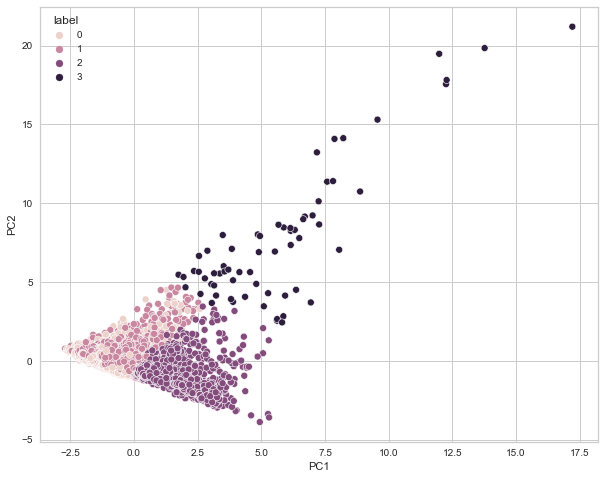

In [28]:
# Plot with Seaborn
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', 
                data=pca_X.assign(label=labels),
                cmap='Pastel',
                hue='label', ax=ax)

In [29]:
from bokeh.io import output_notebook
from bokeh import models, palettes, transform
from bokeh.plotting import figure, show

def bokeh_scatter(
    x,
    y,
    data,
    hue=None,
    label_cols=None,
    size=None,
    legend=None,
    alpha=0.5,
):
    """
    x - x column name to plot
    y - y column name to plot
    data - pandas dataframe
    hue - column name to color by (numeric)
    legend - column name to label by
    label_cols - columns to use in tooltip (None all in dataframe)
    size - size of points in screen space unigs
    alpha - transparency
    """
    output_notebook()
    circle_kwargs = {}
    if legend:
        circle_kwargs["legend"] = legend
    if size:
        circle_kwargs["size"] = size
    if hue:
        color_seq = data[hue]
        mapper = models.LinearColorMapper(
            palette=palettes.viridis(256),
            low=min(color_seq),
            high=max(color_seq),
        )
        circle_kwargs[
            "fill_color"
        ] = transform.transform(hue, mapper)
    ds = models.ColumnDataSource(data)
    if label_cols is None:
        label_cols = data.columns
    tool_tips = sorted(
        [
            (x, "@{}".format(x))
            for x in label_cols
        ],
        key=lambda tup: tup[0],
    )
    hover = models.HoverTool(
        tooltips=tool_tips
    )
    fig = figure(
        tools=[
            hover,
            "pan",
            "zoom_in",
            "zoom_out",
            "reset",
        ],
        toolbar_location="below",
    )

    fig.circle(
        x,
        y,
        source=ds,
        alpha=alpha,
        **circle_kwargs
    )
    show(fig)
    return fig

res = bokeh_scatter("PC1","PC2", 
                    data=pd.concat([pca_X, X], axis=1).assign(label=labels), hue='label', size=10,
                    label_cols=list(X.columns)+['label'],
                   legend='label')

Loading BokehJS ...

# Step 3: Analysis

### Which are the most viewed videos?

In [30]:
# 1 - Understanding the distribution of the likes to apply on the groupby below
y=1000
df_graph=df.views.apply(lambda x: round(x/y,0))
df_graph.describe()

count     5440.000000
mean      2063.652941
std       3569.598818
min          1.000000
25%        670.750000
50%       1300.000000
75%       2100.000000
max      72000.000000
Name: views, dtype: float64

In [31]:
# Top 25 Most Liked videos by taking into account 75% percentile as the cutting point
y_var='likes'
df_grap = (
    (df.groupby(['title','author','date_recorded_year','views'])[y_var].sum().reset_index())
    .sort_values([y_var],ascending=[False])
    ).reset_index()
df_grap=df_grap.drop('index', axis=1)
df_grap = df_grap[df_grap[y_var] > 65000]
print ('Top 25 Liked Videos')
df_grap.head(25)

Top 25 Liked Videos


,title,author,date_recorded_year,views,likes
0,Do schools kill creativity?,Sir Ken Robinson,2006,72000000,2100000
1,The self-organizing computer course,Shimon Schocken,2012,64000000,1900000
2,Inside the mind of a master procrastinator,Tim Urban,2016,60000000,1800000
3,How great leaders inspire action,Simon Sinek,2009,57000000,1700000
4,The power of vulnerability,Brené Brown,2010,56000000,1700000
5,How to speak so that people want to listen,Julian Treasure,2013,49000000,1400000
6,My philosophy for a happy life,Sam Berns,2013,43000000,1300000
7,The next outbreak? We're not ready,Bill Gates,2015,43000000,1300000
8,What makes a good life? Lessons from the longe...,Robert Waldinger,2015,41000000,1200000
9,Could a Saturn moon harbor life?,Carolyn Porco,2009,37000000,1100000


### Are there any authors that have presented more than once?

For this data we will use the raw data obtained by kaggle because some talks were lost during the scrapping. 
Surprisingly there are 536 authors that have presented more than once, most averaging 2 presentations. 
However, 15% of the presenters have presented at least 3 times, one speaker "Alex Gendler" even accounting for 45 talks. 

In [32]:
#obtaining dataset 
raw_data=pd.read_csv('https://github.com/aaas24/code_library/raw/main/ted_talks/1_raw_data/ted-talks-website.csv')
df2=raw_data.copy()
df2

,title,author,date,views,likes,link
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,December 2021,404000,12000,https://ted.com/talks/ozawa_bineshi_albert_cli...
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,February 2022,214000,6400,https://ted.com/talks/sydney_iaukea_the_dark_h...
2,How play can spark new ideas for your business,Martin Reeves,September 2021,412000,12000,https://ted.com/talks/martin_reeves_how_play_c...
3,Why is China appointing judges to combat clima...,James K. Thornton,October 2021,427000,12000,https://ted.com/talks/james_k_thornton_why_is_...
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,October 2021,2400,72,https://ted.com/talks/mahendra_singhi_cement_s...
...,...,...,...,...,...,...
5435,The best stats you've ever seen,Hans Rosling,February 2006,15000000,458000,https://ted.com/talks/hans_rosling_the_best_st...
5436,Do schools kill creativity?,Sir Ken Robinson,February 2006,72000000,2100000,https://ted.com/talks/sir_ken_robinson_do_scho...
5437,Greening the ghetto,Majora Carter,February 2006,2900000,88000,https://ted.com/talks/majora_carter_greening_t...
5438,Simplicity sells,David Pogue,February 2006,2000000,60000,https://ted.com/talks/david_pogue_simplicity_s...


In [33]:
#Modifiable variables
x_var1='author'
y_var='title'
# build data
df_graph=(
    (df2.groupby([x_var1])[y_var].count().reset_index()
    ).sort_values([y_var],ascending=[False])
)
df_graph=df_graph[df_graph[y_var]>1]
print('')
print(df_graph.describe()) 
print('')
print(df_graph.head(20))


            title
count  536.000000
mean     2.858209
std      2.788234
min      2.000000
25%      2.000000
50%      2.000000
75%      3.000000
max     45.000000

                    author  title
148           Alex Gendler     45
1781      Iseult Gillespie     33
2845           Matt Walker     18
152         Alex Rosenthal     15
1283         Elizabeth Cox     13
1338            Emma Bryce     12
962          Daniel Finkel     11
2216         Juan Enriquez     11
933             Dan Finkel      9
1655          Hans Rosling      9
4338      Wendy De La Rosa      9
1609             Greg Gage      9
3029          Mona Chalabi      9
1962            Jen Gunter      9
544             Bill Gates      8
2729         Marco Tempest      7
31                  TED-Ed      7
943           Dan Kwartler      7
1821  Jacqueline Novogratz      6
2213               Joy Lin      6


<AxesSubplot:>

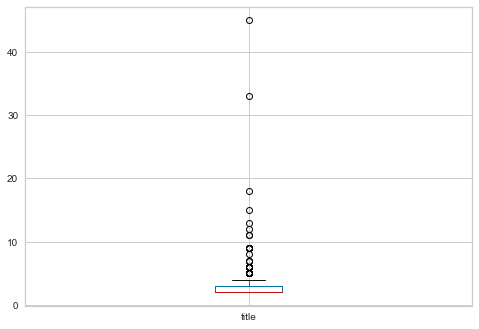

In [34]:
#outliers
df_graph2=(
    df_graph.title
    .reset_index()
    .set_index('index')
)
df_graph2.plot.box()


In [35]:
#Modifiable variables
y_var='views'
x_var1='author'
x_var2='likes'

#build data
df_graph = (
    (df2.groupby([x_var1, x_var2])[y_var].sum().reset_index())
    .sort_values([y_var],ascending=[False])
    ).reset_index().head(20)
df_graph=df_graph.drop('index', axis=1)
df_graph

,author,likes,views
0,Sir Ken Robinson,2100000,72000000
1,Amy Cuddy,1900000,64000000
2,Tim Urban,1800000,60000000
3,Simon Sinek,1700000,57000000
4,Brené Brown,1700000,56000000
5,Julian Treasure,1400000,49000000
6,Sam Berns,1300000,43000000
7,Bill Gates,1300000,43000000
8,Robert Waldinger,1200000,41000000
9,Cameron Russell,1100000,38000000


###  Is there a sustancial difference between liked and viewed?. If so, which are the top videos on each?

Views and likes are directly correlated and although some talks may differ a bit in the order, we can assume they are the same. 

<AxesSubplot:>

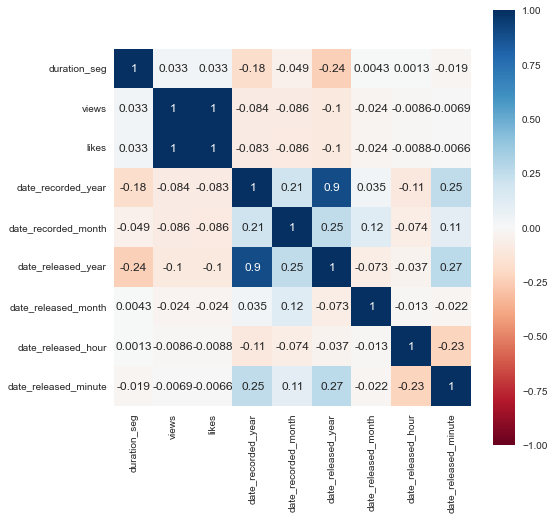

In [36]:
df_graph=df.iloc[:, :14]
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df_graph.corr(), cmap='RdBu', vmin=-1, vmax=1, annot=True, square=True, ax=ax)

### Which content categories are most viewed?

The largest number of talks refer to health (particularly scientific ones) and society and technology

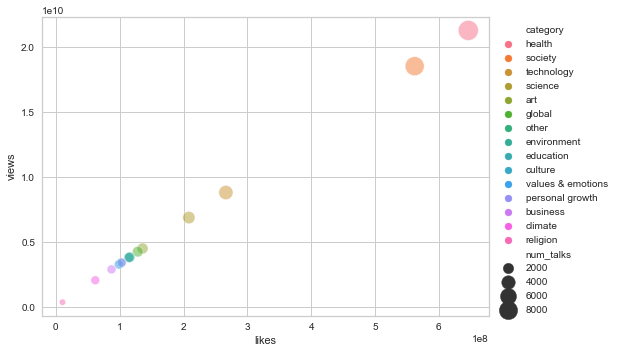

In [37]:
df_graph=(
            df_dummies.
            groupby(['category'])
            .agg({'likes':['sum'],'views':['sum'], 'num_talks':['sum']})
            
)
df_graph.columns=['likes', 'views', 'num_talks']
df_graph=df_graph.sort_values(by=['num_talks'], ascending=False)

#plot
sns.scatterplot(data=df_graph, x="likes", y="views", size="num_talks", legend=True, hue='category', alpha=0.5, sizes=(40, 400)) 
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
sns.axes_style({
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'figure.facecolor': 'white',
     'grid.color': 'white',
     'grid.linestyle': '-',
     'font.sans-serif': 'Arial',
     'grid.color': '#ffffff'

})
sns.set(rc={"figure.figsize":(9 , 9)}) #(width,height)
plt.show()

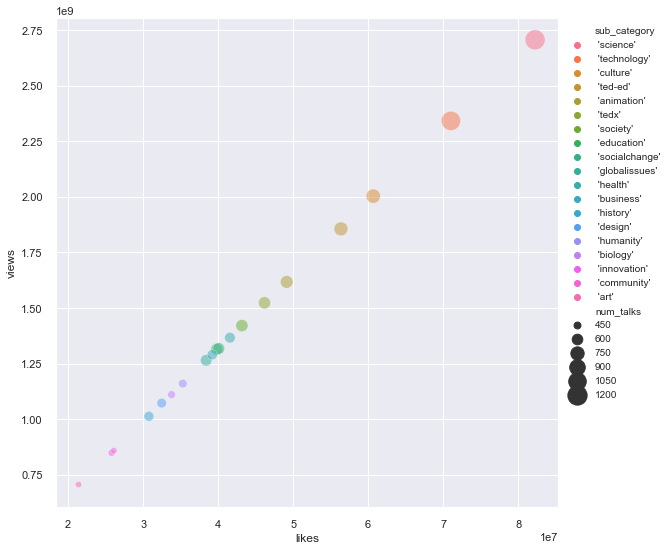

In [38]:
df_graph=(
            df_dummies.
            groupby(['sub_category'])
            .agg({'likes':['sum'],'views':['sum'], 'num_talks':['sum']})
            
)
df_graph.columns=['likes', 'views', 'num_talks']
df_graph=(df_graph
    .sort_values(by=['num_talks'], ascending=False)
    .iloc[1:20,:]
)

# df_graph
# plot
sns.scatterplot(data=df_graph, x="likes", y="views", size="num_talks", legend=True, hue='sub_category', alpha=0.5, sizes=(40, 400)) 
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
sns.axes_style({
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'figure.facecolor': 'white',
     'grid.color': 'white',
     'grid.linestyle': '-',
     'font.sans-serif': 'Arial',
     'grid.color': '#ffffff'

})
sns.set(rc={"figure.figsize":(9 ,9)}) #(width,height)
plt.show()

### Could the duration of the video affect the likebility of the videos?

 In most years, the distribution stays around the first 1000sec (16min40sec). However, in 2020 you can see a lot more liked videos that are far longer, reaching ~4000sec (1hr 46min). I like to think that this can be explained by the worldwide lockdowns during the pandemic, when people were stuck at home with few content options. In that context, it is likely people were more willing to spend more time on ted talks.

<AxesSubplot:>

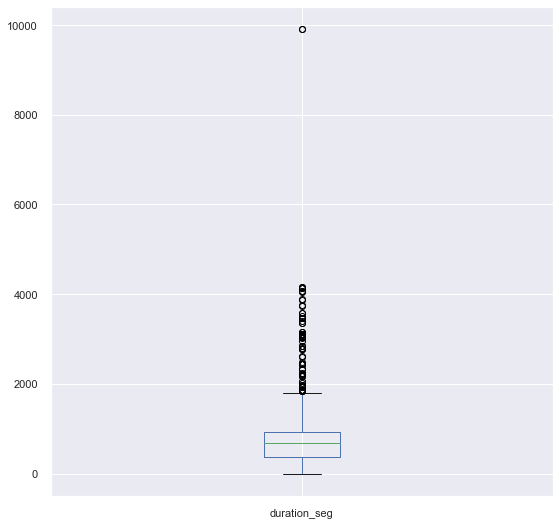

In [39]:
# Are there outliers
df.duration_seg.plot.box()

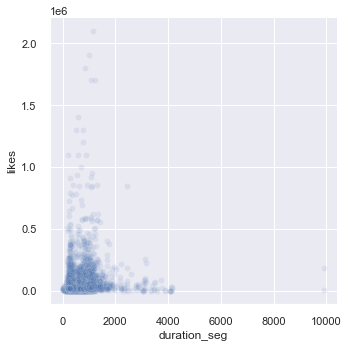

In [40]:
#relationship between duration and likes
df_graph=df
sns.relplot(x='duration_seg', y='likes', data=df_graph, alpha=.1)

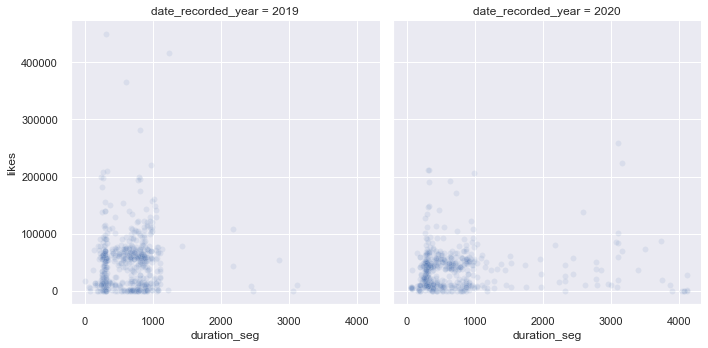

In [41]:
#Insight: during pandemic years (2020-2021) 
df2=df[df.date_recorded_year==2019]
df3=df[df.date_recorded_year==2020]
df_graph=pd.concat([df2,df3 ])
sns.relplot(x='duration_seg', y='likes', data=df_graph, col='date_recorded_year', col_wrap=2, alpha=.1)

### When was the video published? 

Most videos were recorded after 2000. However, there are 8 videos that date dack from that year, going as far as 1970. 

We notice a higher recording on winter months than summer or fall. 

Text(0.5, 1.0, 'Number of Videos Recorded per Year')

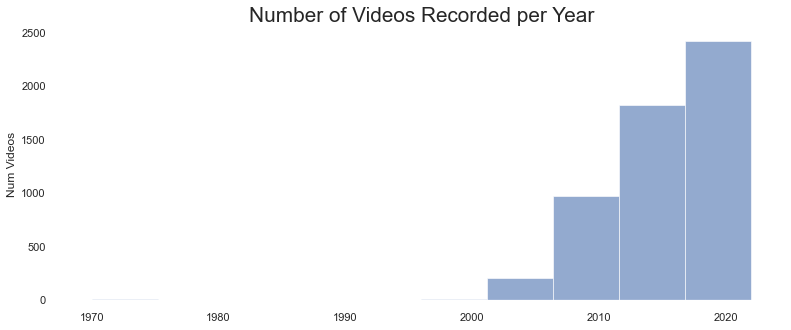

In [42]:
title='Number of Videos Recorded per Year'
y_label='Num Videos'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,5), sharex=True)
ax=df.date_recorded_year.hist(alpha=0.6)
plt.plot(ax=ax)
plt.grid(axis='x')
ax.set_facecolor("white")
ax.set_ylabel(y_label)
plt.grid(axis='y', color='black', alpha=.2)
plt.title(title, ha='center', fontsize='xx-large')

Text(0.5, 1.0, 'Most Videos were Recorded Between 2012-2020')

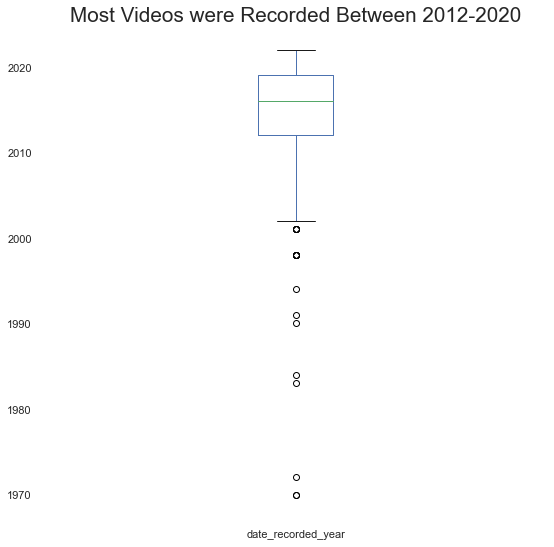

In [43]:
# Are there outliers
title='Most Videos were Recorded Between 2012-2020'
ax=df.date_recorded_year.plot.box()
plt.plot(ax=ax)
plt.grid(axis='x')
ax.set_facecolor("white")
plt.grid(axis='y', color='black', alpha=.2)
plt.title(title, ha='center', fontsize='xx-large')

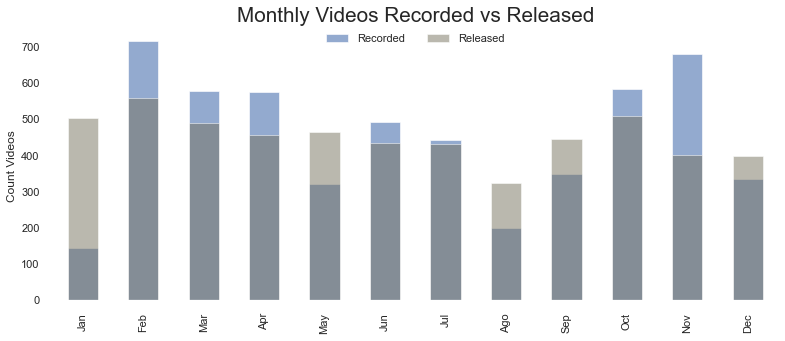

In [44]:
data=df[df.date_recorded_year>2000]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,5), sharex=True)

#plotting first histogram
ax=(data
    .groupby(['date_recorded_month'])
    .likes
    .count()
    .plot(x='date_recorded_month', kind = 'bar',alpha=0.6, ax=ax,) 
)
#plotting second hidtogram
ax=(data
    .groupby(['date_released_month'])
    .likes
    .count()
    .plot(x='date_released_month', kind = 'bar',alpha=0.5, ax=ax, color='#76725e') 
)
#improving labes
ax.set_xticks(ticks=range(0,12,1))  
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('')
ax.set_ylabel('Count Videos ')
#styling grid, leyend and title
plt.title('Monthly Videos Recorded vs Released', ha='center', fontsize='xx-large')
plt.legend(["Recorded", "Released"], loc='upper center',ncol=2, bbox_to_anchor=(0.5, 1.1), borderaxespad=2.6, facecolor="white")
ax.set_facecolor("white")
plt.grid(axis='y', color='black', alpha=.2)

# Step 4: Machine Learning

## A) Predicting model for if a video will perform well:
The goal is to predict a "good performance" for a given video, when we are defining 'good performance' as at least 75% percentile. 

We run 4 different models: 

|Model|Y_Prediction|
|--|--|
|Logistic Regression|0.56|
|Simple Tree|0.59|
|Random Forest|0.64|
|X-Boost|0.68|

Based on the Best Performing Models "XG-Boost", the key features are: 

<br>
- Date related variables, whre we can see that for well performing videos: 

* there were more videos performing better with 5 min duration. Underperforming videos tended to last longer
* Well performing videos tended to be released during spring

<br>
- Keywords related to: 

* Personal Growth: personality, goals, motivation, collaboration, communication, humanity, self, performance, creativity
* Work: business, work-life balance , productivity, 
* Global issues: culture, politics, climate change, planets, gender, virus
* Other topics: music, sports, philosophy, art, health


### Preparing data for models

In [45]:
# #what constitude a good video based on likes?
y=1000
df_graph=df.likes.apply(lambda x: round(x/y,0))
df_graph.describe()

count    5440.000000
mean       62.666912
std       107.730958
min         0.000000
25%        20.000000
50%        41.000000
75%        65.000000
max      2100.000000
Name: likes, dtype: float64

In [46]:
#verifying no NAN in data feeding model
df[df.likes.isnull()==True]

,author,title,description_1,duration_seg,description_2,views,likes,date_recorded_year,date_recorded_month,date_released_year,...,'water','weather','windenergy','women','womeninbusiness','work','work-lifebalance','writing','youth','ted'


In [47]:
#create target

#we define TARGET a well performing video if it is above 75% percentile. So the model should predict if a video will
#perform above 75% percentile
threshold= np.percentile(df.likes, 75)

#create target column
df['target']=[1 if x>threshold else 0 for x in df.likes]

In [48]:
#drop multicolinearity columns
df_d=df.drop(['likes', 'views'], axis=1)

In [49]:
#drop text columns
df_d=df_d.drop(['author', 'title', 'description_1', 'description_2', 'keywords2'], axis=1)


In [50]:
data=df_d.copy()
data.head(3)

,duration_seg,date_recorded_year,date_recorded_month,date_released_year,date_released_month,date_released_hour,date_released_minute,"""alzheimer's""",'','3dprinting',...,'weather','windenergy','women','womeninbusiness','work','work-lifebalance','writing','youth','ted',target
0,834,2021,12,2022,2,9,41,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,2022,2,2022,2,10,13,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,665,2021,9,2022,2,9,51,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [51]:
#Balance data
data.target.value_counts()

0    4098
1    1342
Name: target, dtype: int64

In [52]:
positive_labels = data[data.target==1]
num_positive_labels = positive_labels.shape[0]
num_positive_labels

1342

In [53]:
negative_labels = data[data.target==0].sample(num_positive_labels)
negative_labels.shape

(1342, 357)

In [54]:
balanced_data =  positive_labels.append(negative_labels)
balanced_data.target.value_counts()

1    1342
0    1342
Name: target, dtype: int64

In [55]:
## Splitting data into test splits
y = balanced_data.pop('target')
X = balanced_data

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size = 0.33)
X_train.head()

,duration_seg,date_recorded_year,date_recorded_month,date_released_year,date_released_month,date_released_hour,date_released_minute,"""alzheimer's""",'','3dprinting',...,'water','weather','windenergy','women','womeninbusiness','work','work-lifebalance','writing','youth','ted'
3699,384,2013,6,2013,11,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2971,710,2015,11,2016,2,9,28,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1941,376,2018,8,2018,8,14,45,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3027,864,2015,11,2015,12,10,52,0,0,0,...,0,0,0,0,0,0,0,0,0,1
935,295,2020,4,2020,4,11,9,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Models

#### Logistic Regression

In [57]:
# fit a model
clf = LogisticRegression(penalty='l2').fit(X_train, y_train)
# predict probabilities
predictions = clf.predict_proba(X_test)[:, 1]

/Users/alialvarez/opt/anaconda3/envs/clustering/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


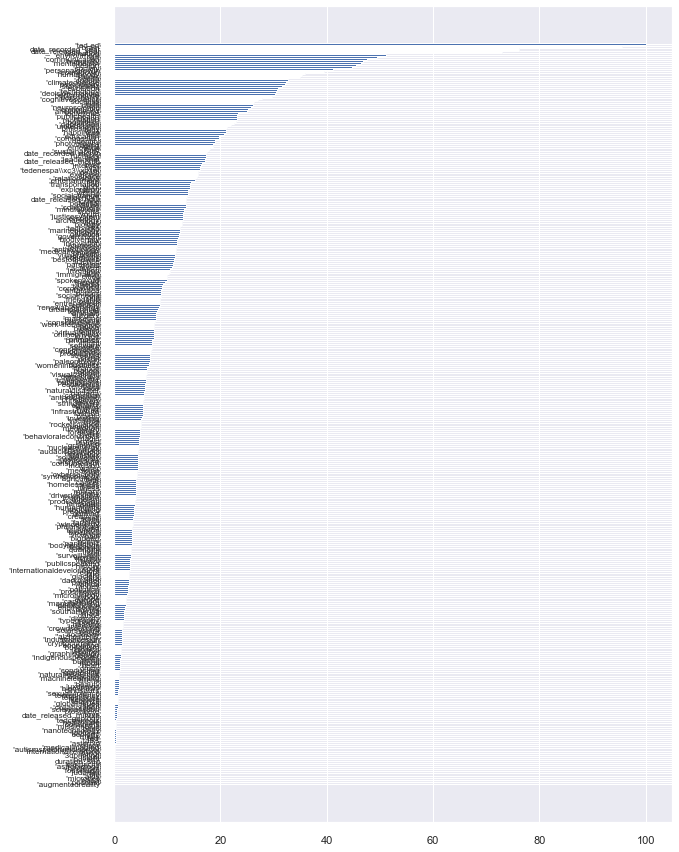

In [58]:
# Feature Importance
feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10, 15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)

plt.show()

<AxesSubplot:>

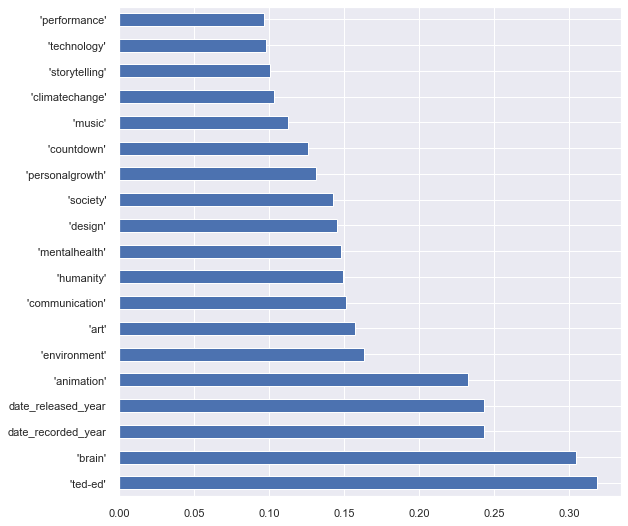

In [59]:
#Zooming into the top 20 features (positives and negatives)
data=abs(pd.Series(clf.coef_[0], index=X.columns.values)
  .sort_values()
  .iloc[[0,1,2,3,4,5, 6, 7, 8, 9,-9, -8, -7, -6, -5, -4, -3, -2, -1]]
  # .plot.barh()
)
data.sort_values(ascending=False).plot.barh()

In [60]:
# Predict probabilities given test data
y_pred = clf.predict_proba(X_test)
pred_reg=y_pred

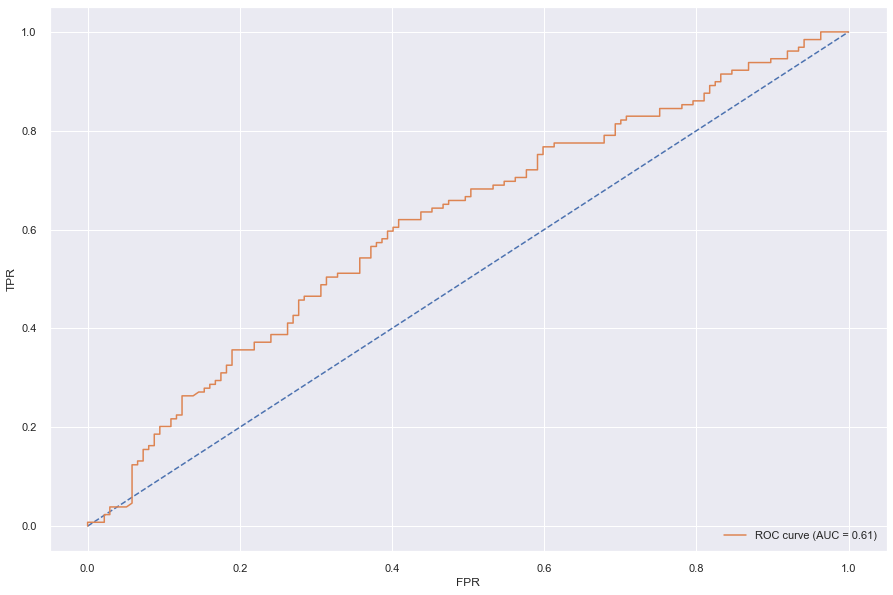

In [61]:
# calculate scores
auc = roc_auc_score(y_test, predictions)

# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, predictions)

plt.figure(figsize=(15, 10))
# plot horizontal line 
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()

####  Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=10)

print(dt_model)

dt_model = dt_model.fit(X_train,y_train)
pred_dt = dt_model.predict_proba(X_valid)[:, 1]

DecisionTreeClassifier(max_depth=10)


In [63]:
from sklearn.metrics import classification_report
pred_dt_binary = dt_model.predict(X_valid)
print(classification_report(y_valid, pred_dt_binary))

              precision    recall  f1-score   support

           0       0.60      0.44      0.51       266
           1       0.57      0.72      0.63       274

    accuracy                           0.58       540
   macro avg       0.58      0.58      0.57       540
weighted avg       0.58      0.58      0.57       540



#### Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
print(rf_model)

rf_model = rf_model.fit(X_train, y_train)
pred_rf = rf_model.predict_proba(X_valid)[:, 1]
print(classification_report(y_valid, pred_rf.round(0)))

RandomForestClassifier()
              precision    recall  f1-score   support

           0       0.64      0.59      0.61       266
           1       0.63      0.68      0.65       274

    accuracy                           0.63       540
   macro avg       0.63      0.63      0.63       540
weighted avg       0.63      0.63      0.63       540



<BarContainer object of 356 artists>

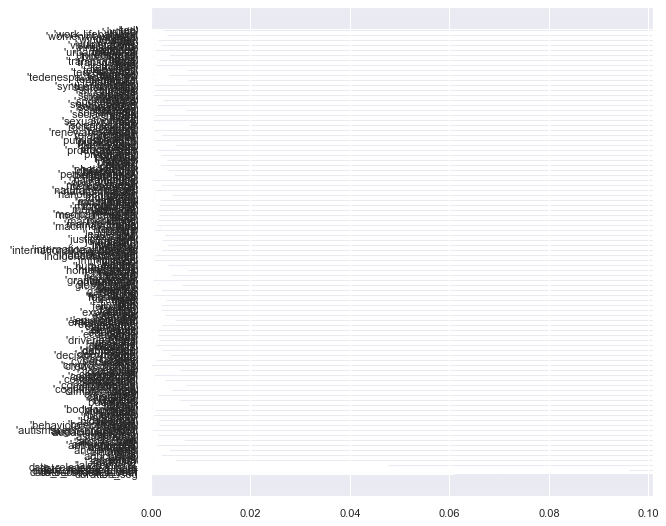

In [65]:
#Feature Component
from sklearn.inspection import permutation_importance
rf_model.feature_importances_
plt.barh(X.columns.values, rf_model.feature_importances_)

<AxesSubplot:>

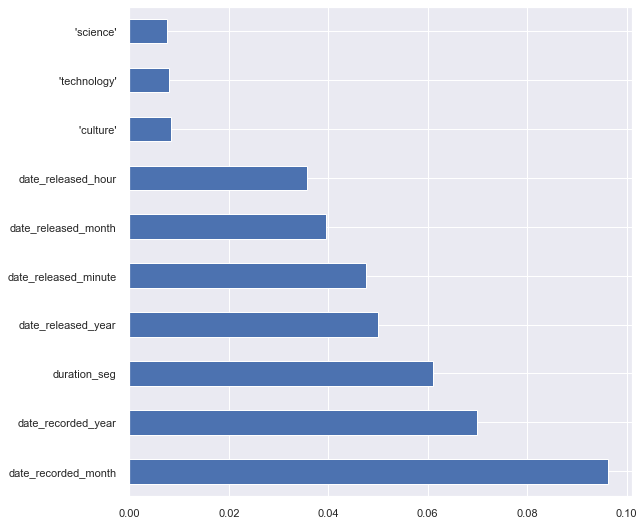

In [66]:
(pd.Series(rf_model.feature_importances_, index=X.columns.values)
  .sort_values(ascending=False)
  .iloc[:10]
  .plot.barh()
)


#### XGBoost

In [67]:
#code to fix error taken from: https://stackoverflow.com/questions/43579180/feature-names-must-be-unique-xgboost
X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_valid = X_valid.loc[:,~X_valid.columns.duplicated()]

In [68]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()

xgb_model = xgb_model.fit(X_train, y_train)
pred_xgb = xgb_model.predict_proba(X_valid)[:, 1]

/Users/alialvarez/opt/anaconda3/envs/clustering/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:04:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


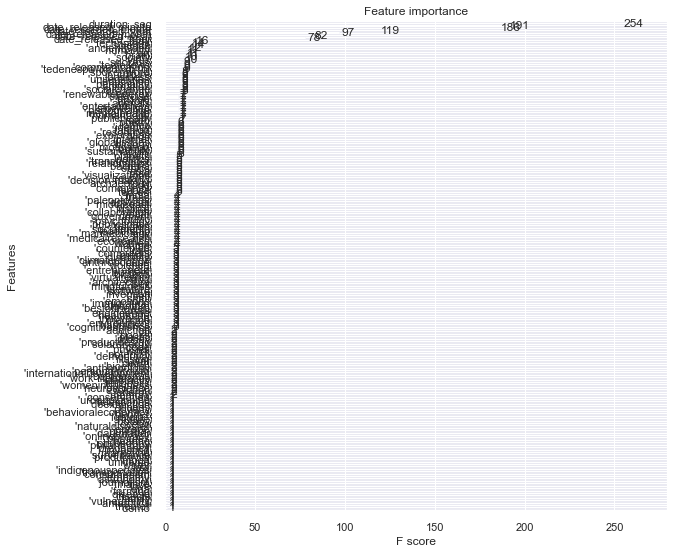

In [69]:
#Feature Component
from xgboost import plot_importance
# plot feature importance
plot_importance(xgb_model)
plt.show()

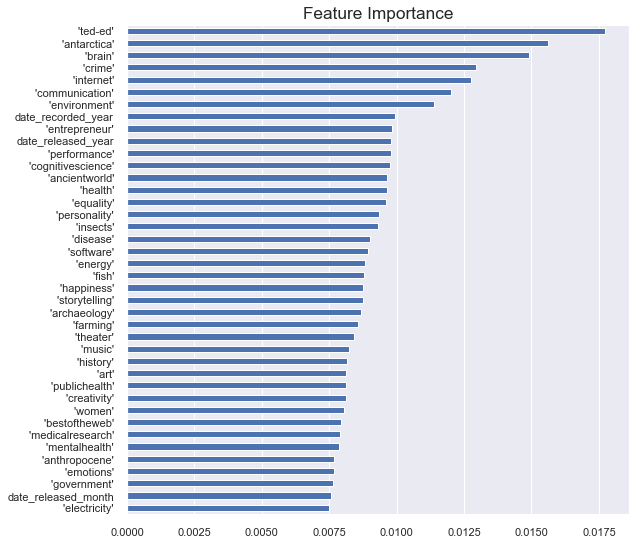

In [70]:
df_graph=(pd.Series(xgb_model.feature_importances_, index=X.columns.values)
  .sort_values(ascending=False)
  .iloc[:40]
  .sort_values(ascending=True)
  .plot.barh()
)

#improving labels
ax.set_xlabel('Importance')
ax.set_ylabel('Features ')


#styling grid, leyend and title
plt.title('Feature Importance', ha='center', fontsize='x-large')
ax.set_facecolor("white")
plt.grid(axis='y', color='black', alpha=.2)

### Comparing Tree Models

In [71]:
y_pred = clf.predict_proba(X_test)
pred_reg=y_pred[:, 1]

In [72]:
def create_roc_plot(name, predictions):
    if name == 'Logistic':
        auc = roc_auc_score(y_test, predictions).round(2)
        fpr, tpr, _ = roc_curve(y_test, predictions)
    else: 
        auc = roc_auc_score(y_valid, predictions).round(2)
        fpr, tpr, _ = roc_curve(y_valid, predictions)

    plt.figure(figsize=(5, 4))
    plt.plot([0, 1], [0, 1], linestyle='--')  # plot horizontal line 
    plt.plot(fpr, tpr, label='{} AUC = {}'.format(name, auc)) # plot the roc curve for the model
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc='lower right')  # show the legend
    plt.show() # show the plot
    
    return None

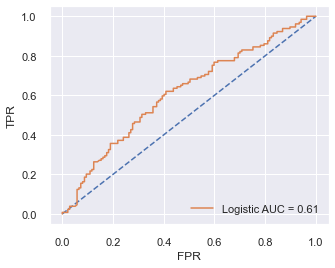

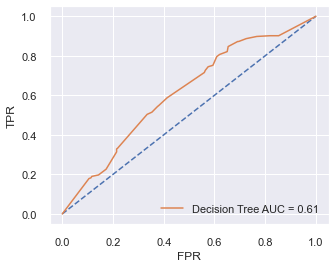

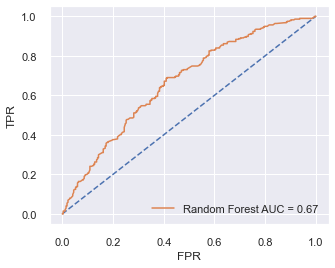

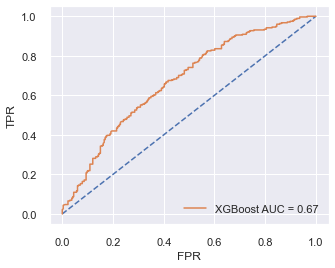

In [73]:
create_roc_plot('Logistic', pred_reg)
create_roc_plot('Decision Tree', pred_dt)
create_roc_plot('Random Forest', pred_rf)
create_roc_plot('XGBoost', pred_xgb)

### Understanding video_duration as key feature

In [74]:
df.duration_seg.describe()

count    5440.000000
mean      711.460846
std       463.023031
min         0.000000
25%       361.750000
50%       686.000000
75%       934.000000
max      9915.000000
Name: duration_seg, dtype: float64

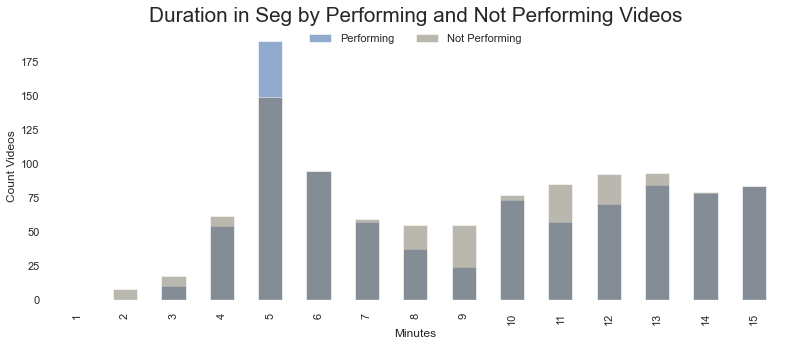

In [75]:
step=60
bar=list(np.arange(0, 934,step))
# bar.append(9915)

df2=pd.concat([X,y], axis=1)
df_graph=df2.loc[:,['duration_seg', 'target']]
df_graph=(df_graph    
  .assign(bin=pd.cut(df_graph.duration_seg, bar))
  .groupby(['bin', 'target'])
  .size()
  .unstack()
)

dfgraph_y=df_graph.iloc[:,1]
dfgraph_n=df_graph.iloc[:,0]

#improving graph
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,5), sharex=True)

#plotting first histogram
ax=(dfgraph_y.plot( kind = 'bar',alpha=0.6, ax=ax,))

#plotting second histogram
ax=(dfgraph_n.plot( kind = 'bar',alpha=0.5, ax=ax, color='#76725e'))

#improving labels
ax.set_xlabel('Minutes')
ax.set_ylabel('Count Videos ')
ax.set_xticks(ticks=range(0,len(bar)-1,1))  
ax.set_xticklabels(range(1,len(bar),1))

#styling grid, leyend and title
plt.title('Duration in Seg by Performing and Not Performing Videos', ha='center', fontsize='xx-large')
plt.legend(["Performing", "Not Performing"], loc='upper center',ncol=2, bbox_to_anchor=(0.5, 1.1), borderaxespad=2.6, facecolor="white")
ax.set_facecolor("white")
plt.grid(axis='y', color='black', alpha=.2)

### Understanding date_released_month as key feature

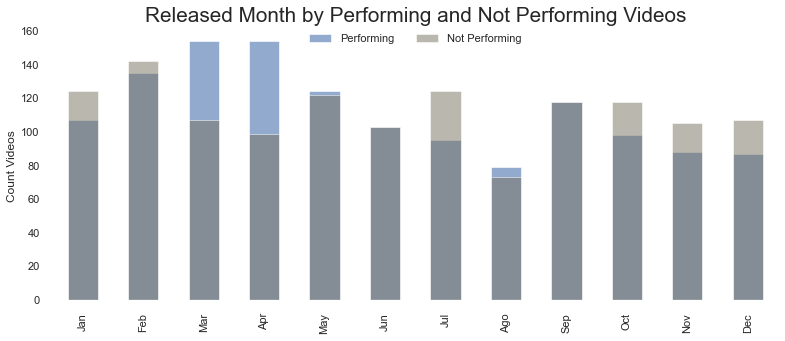

In [76]:
df2=pd.concat([X,y], axis=1)
df_graph=df2.loc[:,['date_released_month', 'target']]
dfgraph_y=df_graph[df_graph.target==1]
dfgraph_n=df_graph[df_graph.target==0]



#improving graph
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,5), sharex=True)

# #plotting first histogram
ax=(dfgraph_y.groupby(['date_released_month'])
    .agg({'target':['sum']})
    .plot( kind = 'bar',alpha=0.6, ax=ax,) 
)
# #plotting second histogram
ax=(dfgraph_n.groupby(['date_released_month'])
    .agg({'target':['count']})
    .plot( kind = 'bar',alpha=0.5, ax=ax, color='#76725e') 
)

# # #improving labels

ax.set_xticks(ticks=range(0,12,1))  
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('')
ax.set_ylabel('Count Videos ')

#styling grid, leyend and title
plt.title('Released Month by Performing and Not Performing Videos', ha='center', fontsize='xx-large')
plt.legend(["Performing", "Not Performing"], loc='upper center',ncol=2, bbox_to_anchor=(0.5, 1.1), borderaxespad=2.6, facecolor="white")
ax.set_facecolor("white")
plt.grid(axis='y', color='black', alpha=.2)

### Understanding date_released_year as key feature

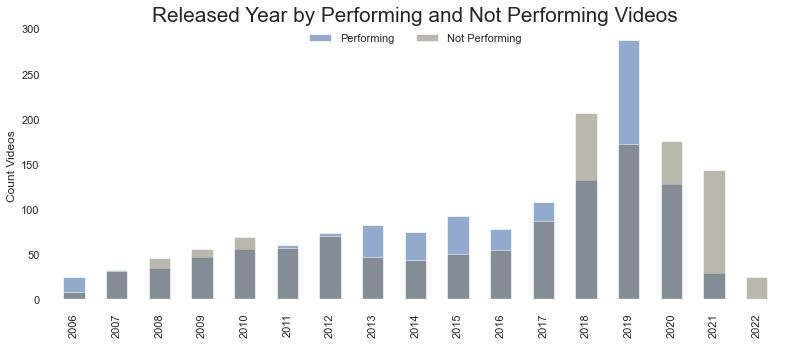

In [77]:
df2=pd.concat([X,y], axis=1)
df_graph=df2.loc[:,['date_released_year', 'target']]
dfgraph_y=df_graph[df_graph.target==1]
dfgraph_n=df_graph[df_graph.target==0]



#improving graph
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,5), sharex=True)

# #plotting first histogram
ax=(dfgraph_y.groupby(['date_released_year'])
    .agg({'target':['sum']})
    .plot( kind = 'bar',alpha=0.6, ax=ax,) 
)
# #plotting second histogram
ax=(dfgraph_n.groupby(['date_released_year'])
    .agg({'target':['count']})
    .plot( kind = 'bar',alpha=0.5, ax=ax, color='#76725e') 
)

# # #improving labels
ax.set_xlabel('')
ax.set_ylabel('Count Videos ')

#styling grid, leyend and title
plt.title('Released Year by Performing and Not Performing Videos', ha='center', fontsize='xx-large')
plt.legend(["Performing", "Not Performing"], loc='upper center',ncol=2, bbox_to_anchor=(0.5, 1.1), borderaxespad=2.6, facecolor="white")
ax.set_facecolor("white")
plt.grid(axis='y', color='black', alpha=.2)

## B) ML Recommendation of Ted Talk

The goal is to recommend a ted talk based on a previous liked one

In [99]:
review=df.description_1
title=df.title

In [100]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')#max_features=5000

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(review)

#Output the shape of tfidf_matrix
tfidf_matrix.shape

#create matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [101]:
indices = (pd.Series(df.index, index=title)
    .reset_index()
    .drop_duplicates(subset=['title'], keep='first')
    ).set_index('title')
          
indices.columns=['index']
indices=indices.squeeze()
indices

title
Climate action needs new frontline leadership                  0
The dark history of the overthrow of Hawaii                    1
Why play is essential for business                             2
Why is China appointing judges to combat climate change?       3
Cement's carbon problem -- and 2 ways to fix it                4
                                                            ... 
Let's teach religion -- all religion -- in schools          5431
Letting go of God                                           5433
Do schools kill creativity?                                 5436
Greening the ghetto                                         5437
Averting the climate crisis                                 5439
Name: index, Length: 3014, dtype: int64

In [102]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the talk that matches the title
    idx = indices[title]

#     Get the pairwsie similarity scores of all talks with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
#     Sort the talk based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

#     Remove duplicates scores 
    sim_scores=pd.Series(v[0] for v in sim_scores).drop_duplicates()

    # Get the talk indices
    recommendations=(
        df.title.iloc[sim_scores]
        .drop_duplicates()
        [1:11]
        .reset_index()
    ).drop('index', axis=1)
 
    # Return the top 10 most similar values
    return recommendations

In [103]:
talk_liked='Can machines read your emotions?'

indices[talk_liked]

2732

In [104]:
# change display option to be able to see ful title name
pd.set_option('display.max_colwidth', None)
get_recommendations(talk_liked)

,title
0,How computer memory works
1,What's it like to be a robot?
2,Why incompetent people think they're amazing
3,The wonderful and terrifying implications of computers that can learn
4,The rise of personal robots
5,What is the Heisenberg Uncertainty Principle?
6,Make robots smarter
7,Older people are happier
8,Diversity in harmony
9,Why do your knuckles pop?


In [105]:
#compare results of recommendation engine
df_graph=df.query('title.str.contains("machines", "emotions")', engine='python')
df_graph[['author', 'title', 'likes']].drop_duplicates(subset='title').sort_values(by=['likes'], ascending=False)

,author,title,likes
2977,Raffaello D'Andrea,Meet the dazzling flying machines of the future,302000
2835,Anthony Goldbloom,The jobs we'll lose to machines -- and the ones we won't,85000
2571,Garry Kasparov,Don't fear intelligent machines. Work with them,56000
2752,Tim Leberecht,4 ways to build a human company in the age of machines,50000
3894,Erik Brynjolfsson,The key to growth? Race with the machines,41000
2473,Radhika Nagpal,What intelligent machines can learn from a school of fish,39000
2732,Kostas Karpouzis,Can machines read your emotions?,9300
3138,Markus Lorenz,Industry 4.0: how intelligent machines will transform everything we know,6400


# Conclusion


### General Findings

#### * Which are the most viewed videos?
Do schools kill creativity? from Sir Ken Robinson, 'The self-organizing computer course' from Shimon Schocken and 'Inside the mind of a master procrastinator' from Tim Urban are the top three videos in our dataset. 

#### * Is there a sustancial difference between liked and viewed?
Views and likes are directly correlated, so there is very little difference in the classification videos have based on either of them. 

#### * Are there any authors that have presented more than once?
Yes!, in fact many. And even though the majority only had up to 2 talks, there are some interetsing outliers like Alex Genndler who has 45 talks so far. 

#### * Which content categories are most viewed?
Health, Society and Technology and general subjects. 

#### * Could the duration of the video affect the likebility of the videos?
In most years, the distribution stays around the first 1000sec (16min40sec). However, in 2020 you can see a lot more liked videos that are far longer, reaching ~4000sec (1hr 46min). I like to think that this can be explained by the worldwide lockdowns during the pandemic, when people were stuck at home with few content options. In that context, it is likely people were more willing to spend more time on ted talks.

#### * When was the video published?
The dataset contained mostly videos published after 2000. However, 8 outliers are present dating back to 1970.


### Other techniques we can apply
1) In order to answer properly the question 'Which content categories are made available the most?', we should compare the keywords used in the website with labels we can identify from the talks descriptions. For this we coul use a Name Entity Classifier (NEC) Model, such as this: 

``` python
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")


list_text = []
list_ent = []
count_row=0


for row in df.description_2:
  count_row=count_row+1
  text=row
  doc = nlp(text)
#   displacy.render(doc, style='ent', jupyter=True)
  for ent in doc.ents:
      # print(ent.text, ent.label_)
      list_text.append(ent.text)
      list_ent.append(ent.label_)
      

text_df = pd.DataFrame(list_text, columns=['text'])
text_df['ent'] = list_ent

print(text_df)
```
2) The question about "* What type of event was this part of? Was it a Women, or a specific location?" was not answered as the scrapping data did not contained this information. We would need to modify the scapping code in order to find those fields. 

### Areas of improvements:
1) We uncovered that when the data scrapped was joined with the kaggle data some values were dropped. Further investigation should go into why those talks were not succesfully scrapped in order to have more values in the data set

2) Another area of improvement is how we evaluate well performing videos in this analysis as we described a perforing video as one that had reached the 75% percentile. This of course would be an unfair measurement for the recently released videos. Given that we do not have different timestamps on the likes or views for each video, is we should evaluate a better way to estimate or compare recently released content so we can detect earlier when a new video might be performing well. 


3) More information on the authors. Understanding age, gender and nationality of authors, may answer questions related to diversity of the speakers. This data could be parcially scrapped from Wikipedia as there is a dedicated website that tracks this information. 
https://en.wikipedia.org/wiki/List_of_TED_speakers


4) Improvements on recommendation engine. The current model's outputs does not perform well against a simple df.query using keywords from the title. The model currently used is based on TF-IDF (term frequency and Inverse Document frequency) applied to the talk description. The model could be improved by adding other variables available like: keywords, likes & author. 